# Conditional Mixture Models
## Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.random import multivariate_normal, rand, seed

In [57]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

Consider $K$ logistic regression models ($f_k: \mathbb{R}^M\to[0,1]$), each governed by its own weight vector ${\bf w}_k$. To make a **mixture of logistic regressions**, we consider a set of weighting coefficients $\{\pi_k\}_k$ and a mixture distribution given by

$$
\begin{aligned}
    p({\bf t}\vert \boldsymbol\theta,\boldsymbol\phi) &= \sum_{k=1}^K \pi_k \text{Bern}\big(t_n\vert\sigma\left({\bf w}_k^T\boldsymbol\phi_n\right)\big)\\
    &= \sum_{k=1}^K \pi_k \sigma\left({\bf w}_k^T\boldsymbol\phi_n\right)^{t_n}\left(1 -  \sigma\left({\bf w}_k^T\boldsymbol\phi_n\right)\right)^{1-t_n}\\
\end{aligned}
$$

Where $\boldsymbol\theta=\big\{\{{\bf w}_k\}_k, \{\pi_k\}_k\big\}$

In order to find the values of $\boldsymbol\theta$, we make use of th EM algorithm by introducing latent variables ${\bf Z}=\{{\bf z}_n\}_n$. The EM algorithm then turns in finding the coefficients

$$
\gamma_{nk} = \frac{\pi_k\text{Bern}\big(t_n\vert\sigma\left({\bf w}_k^T\boldsymbol\phi_n\right)\big)}{\sum_j\pi_j\text{Bern}\big(t_n\vert\sigma\left({\bf w}_j^T\boldsymbol\phi_n\right)\big)}
$$

for the **E-step**, and maximizing

$$
Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}}) = \sum_{n=1}^N\sum_{k=1}^K \gamma_{nk}\big[\log\pi_k +  t_n\log\sigma\left({\bf w}^T_k\boldsymbol\phi_n\right) + (1 - t_n)\log\left(1 - \sigma\left({\bf w}^T_k\boldsymbol\phi_n\right)\right)\big]
$$

w.r.t. each component of $\boldsymbol\theta$ for the **M-step**.

The M-step results updating the equations:

$$
\pi_k^\text{new} = \frac{1}{N}\sum_{n=1}^N\gamma_{nk}
$$

And updating ${\bf w}_k$ using the IRLS algorithm (see chapter4) as:

$$
    {\bf w}_k := {\bf w}_k - {\bf H}^{-1}\nabla {\mathcal L}_{{\bf k}_k}({\bf w})
$$

With

$$
\nabla {\mathcal L}_{{\bf k}_k}({\bf w}) = \sum_{n=1}^N\gamma_{nk}\left[t_n - \sigma\left({\bf w}^T_k\boldsymbol\phi_n\right)\right]\boldsymbol\phi_n
$$

$$
{\bf H} = -\sum_{n=1}^N \sigma\left({\bf w}^T_k\boldsymbol\phi_n\right)\left[1 - \sigma\left({\bf w}^T_k\boldsymbol\phi_n\right)\right]\boldsymbol\phi_n\boldsymbol\phi_n^T
$$

In [58]:
mus = np.array([
    [0, -2],
    [-2, 0],
    [0, 2],
    [2, 0]
])
cat = np.array([0, 1, 0, 1])

sigma = 0.5
n_samples = 100
X = []
y = []

for mu, c in zip(mus, cat):
    X_sample = multivariate_normal(mean=mu, cov=np.eye(2) * sigmari, size=n_samples)
    y_sample = np.ones(n_samples) * c
    
    X.append(X_sample)
    y.append(y_sample)

X = np.concatenate(X)
y = np.concatenate(y)

D = np.c_[X, y]
np.random.shuffle(D)

X, y = D[:, :2], D[:, -1]

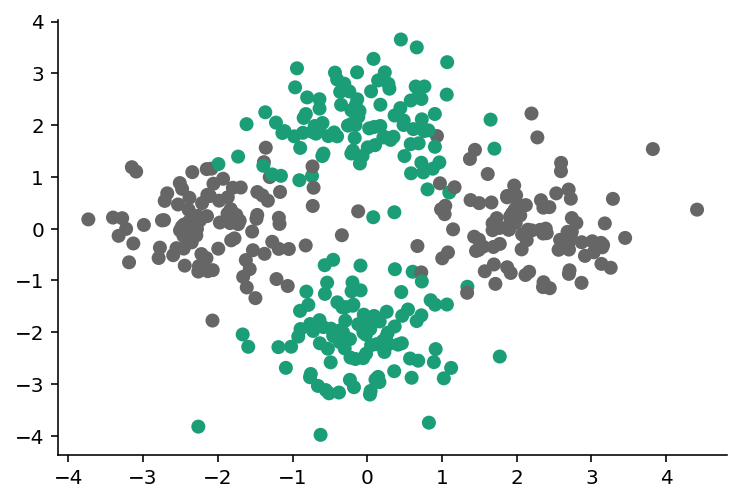

In [59]:
plt.scatter(*X.T, c=y, cmap="Dark2")